Example notebook to train a resnet classfication model and then make predictions

In [ ]:
import pandas as pd
import os
import matplotlib
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet import ResNet101
from keras.models import Model
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, Activation, GlobalAveragePooling2D, BatchNormalization
from keras.models import Sequential
from keras import optimizers
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.utils import shuffle
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import preprocess_input

In [2]:
#Check if GPU can be found and is built with cuda
print(tf.config.experimental.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [3]:
#Store path
train_dir = 'FOODX-251_Dataset/train_set/'
val_dir = 'FOODX-251_Dataset/val_set/'
#Macornutrient data
macro_df = pd.read_csv('FOODX-251_Dataset/macro_data_foodX251.csv')

#Merge macronutrient data with image labels for train and validation set. 
train_df = pd.read_csv('FOODX-251_Dataset/train_labels.csv')

train_names, val_names = train_test_split(train_df, test_size = 0.15, random_state=42)
m_train_df = pd.merge(train_names, macro_df, on='label')

# m_train_df = pd.merge(train_df, macro_df, on='label')
m_val_df = pd.merge(val_names, macro_df, on='label')

# df2 = m_train_df.loc[m_train_df['label'] == 162]
# df2.head(1000)

In [4]:
# # m_train_df.label.hist()
# m_train_df['label'].value_counts()

In [5]:
# m_val_df['label'].value_counts()

In [6]:
m_train_df = shuffle(m_train_df)
m_val_df = shuffle(m_val_df)
#df2 = m_val_df.loc[m_val_df['label'] == 247]
#m_train_df = m_train_df.head(10000)

In [7]:
#m_val_df = m_val_df.head(10000)

In [8]:
test_df = pd.read_csv('FOODX-251_Dataset/val_labels.csv')
m_test_df = pd.merge(test_df, macro_df, on='label')
m_test_df.head()

,img_name,label,Energy,Protein,Fat,Carbohydrate
0,val_010323.jpg,247,339.0,4.07,19.24,39.84
1,val_010350.jpg,247,339.0,4.07,19.24,39.84
2,val_010389.jpg,247,339.0,4.07,19.24,39.84
3,val_010404.jpg,247,339.0,4.07,19.24,39.84
4,val_010471.jpg,247,339.0,4.07,19.24,39.84


In [9]:
print(m_train_df.shape)
print(m_val_df.shape)
print(m_test_df.shape)

(100703, 6)
(17772, 6)
(11994, 6)


In [10]:
scaler = MinMaxScaler(feature_range=(0.01, 0.99))
m_train_df[['Energy' , 'Protein' , 'Fat' , 'Carbohydrate']] = scaler.fit_transform(m_train_df[['Energy' , 'Protein' , 'Fat' , 'Carbohydrate']])


m_val_df[['Energy' , 'Protein' , 'Fat' , 'Carbohydrate']] = scaler.fit_transform(m_val_df[['Energy' , 'Protein' , 'Fat' , 'Carbohydrate']])
m_train_df.head()

,img_name,label,Energy,Protein,Fat,Carbohydrate
30836,train_059598.jpg,0,0.884582,0.305181,0.467268,0.634413
97460,train_054633.jpg,18,0.357490,0.472548,0.281264,0.028265
19639,train_063091.jpg,37,0.154462,0.096193,0.023132,0.225670
26563,train_109917.jpg,228,0.285259,0.196259,0.171700,0.190662
74834,train_034374.jpg,66,0.322351,0.477566,0.181108,0.109873


In [11]:
#Setup ResNet101 removing top
resnet1 = ResNet101(include_top=False, weights='imagenet', input_shape=[150,150,3])#, pooling='avg'
# output = resnet.layers[-1].output
# output = keras.layers.Flatten()(output)
# resnet = Model(resnet.input, outputs=output)

#Freeze ResNet layers
# for layer in resnet.layers:
#     layer.trainable = False
    
# model_transfer_full = Sequential()
# x = resnet.output
# x = Flatten()(x)
# x = Dense(256, activation='relu')(x)
# # x = BatchNormalization()(x)
# x = Dropout(0.3)(x)
# predictions = Dense(251, activation='softmax')(x)
# # model_transfer_full.add(resnet)
# # model_transfer_full.add(Dense(300, activation='relu'))
# # model_transfer_full.add(GlobalAveragePooling2D())
# # model_transfer_full.add(Dropout(0.5))
# model_transfer_full = Model(inputs=resnet.input, outputs=predictions)
# # model_transfer_full.add(Dense(251, activation='softmax'))
# model_transfer_full.summary()

In [12]:
model = Sequential()
model.add(resnet1)

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(251, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 5, 5, 2048)        42658176  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              52429824  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 251)              

In [13]:
# base_model = ResNet101(include_top=False, weights="imagenet", input_shape=(100,100,3))
# x = Flatten()(base_model.output)
# x = Dense(251, activation="softmax")(x)
# model = Model(base_model.input, x)

# for layer in base_model.layers:
#     layer.trainable = False
# model.save_weights("all_nontrainable.h5")

# base_model = ResNet101(include_top=False, weights="imagenet", input_shape=(100, 100, 3))
# x = Flatten()(base_model.output)
# x = Dense(251, activation="softmax")(x)
# #Try sigmoid
# model = Model(base_model.input, x)

# for layer in base_model.layers[:-51]:
#     layer.trainable = False
# model.load_weights("all_nontrainable.h5")
# # base_model = tf.keras.applications.MobileNetV2(input_shape=(100, 100, 3),
# #                                                include_top=False,
# #                                                weights='imagenet')

In [14]:
# base_model.trainable = False
# base_model.summary()

In [15]:
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = (64, 5, 5, 1280)
# print(feature_batch_average.shape)
import functools
top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)

top3_acc.__name__ = 'top3_acc'

In [16]:
#model = Sequential()
#model.add(resnet)
#Add layer for regression prediction
#model.add(Dense(4, activation='linear'))
adam = Adam(lr=0.00005)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy' ,top3_acc])
#model_transfer_full.summary()

In [17]:
m_train_df['label'] = m_train_df['label'].apply(str)
m_val_df['label'] = m_val_df['label'].apply(str)
m_test_df['label'] = m_test_df['label'].apply(str)
#Set up keras generators for extracting image informationa and for preprocessing
columns=["Energy", "Protein", "Fat", "Carbohydrate"]


train_datagen = ImageDataGenerator(
        rescale=1.0/255.0, 
        shear_range=0.2,
        zoom_range=0.2,
#         preprocessing_function=preprocess_input,
        horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1.0/255.0)
train_generator = train_datagen.flow_from_dataframe(
        dataframe=m_train_df,
        directory="./FOODX-251_Dataset/train_set",
        x_col = 'img_name', 
        y_col = 'label',
        batch_size = 64,
        seed = 42,
        shuffle=True,
        class_mode="categorical",
        target_size=(150,150))  

valid_generator=train_datagen.flow_from_dataframe(
        dataframe=m_val_df,
        directory="./FOODX-251_Dataset/train_set",
        x_col='img_name',
        y_col='label',
        batch_size=64,
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=(150,150))

test_generator=test_datagen.flow_from_dataframe(
        dataframe=m_test_df,
        directory="./FOODX-251_Dataset/val_set",
        x_col='img_name',
        y_col='label',
        batch_size=1,
        seed=42,
        shuffle=False,
        class_mode="categorical",
        target_size=(150,150))
#plt.imshow(images[1])

Found 100703 validated image filenames belonging to 251 classes.
Found 17772 validated image filenames belonging to 251 classes.
Found 11994 validated image filenames belonging to 251 classes.


In [18]:
from keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

In [19]:
callbacks = [LearningRateScheduler(lr_scheduler, verbose=1)]

In [20]:
#Wrapper to have multiple outputs
# def generator_wrapper(generator):
#     for batch_x,batch_y in generator:
#         yield (batch_x,[batch_y[:,i] for i in range(4)])

In [ ]:
#Fit the model
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    callbacks=callbacks,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50
)


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
1573/1573 [==============================] - 659s 419ms/step - loss: 5.4637 - accuracy: 0.0180 - top3_acc: 0.0412 - val_loss: 4.8535 - val_accuracy: 0.1011 - val_top3_acc: 0.1954
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
1573/1573 [==============================] - 640s 407ms/step - loss: 4.5422 - accuracy: 0.1158 - top3_acc: 0.2158 - val_loss: 3.8416 - val_accuracy: 0.2394 - val_top3_acc: 0.4024
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
1573/1573 [==============================] - 637s 405ms/step - loss: 3.8483 - accuracy: 0.2127 - top3_acc: 0.3573 - val_loss: 2.9812 - val_accuracy: 0.3047 - val_top3_acc: 0.4838
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
1573/1573 [==============================] - 636s 404ms/step - loss: 3.4258 - accu

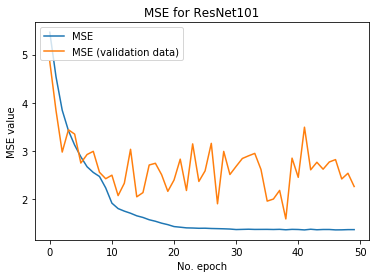

In [30]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MSE ')
plt.plot(history.history['val_loss'], label='MSE (validation data)')
plt.title('MSE for ResNet101')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [37]:
# Plot history: MAE
# plt.plot(history.history['mean_squared_error'], label='MAE ')
# plt.plot(history.history['val_mean_squared_error'], label='MAE (validation data)')
# plt.title('MAE for ResNe101')
# plt.ylabel('MAE value')
# plt.xlabel('No. epoch')
# plt.legend(loc="upper left")
# plt.show()

In [73]:
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

11994/11994 [==============================] - 209s 17ms/step


In [39]:
# results=pd.DataFrame(pred, columns=columns)

acc= model.evaluate_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)


11994/11994 [==============================] - 218s 18ms/step


In [40]:
print(acc)
print(model.metrics_names)

[3.0848612785339355, 0.5345172882080078, 0.7185259461402893]
['loss', 'accuracy', 'top3_acc']


In [116]:
topThreeMapped = []
topThree = []
pred2 = pred.copy()
# Get actual label
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

# Get max
top1 = pred2.argmax(axis=1)
# Map to actual
top11 = [labels[k] for k in top1]
# Convert to int
for i in range(0, len(top11)): 
    top11[i] = int(top11[i]) 
# Set max to zero(to get next highest)
for i in range(len(top1)):
    pred2[i][top1[i]] = 0

top2 = pred2.argmax(axis=1)
top22 = [labels[k] for k in top2]
for i in range(0, len(top22)): 
    top22[i] = int(top22[i]) 

for i in range(len(top2)):
    pred2[i][top2[i]] = 0

top3 = pred2.argmax(axis=1)
top33 = [labels[k] for k in top3]
for i in range(0, len(top33)): 
    top3[i] = int(top33[i]) 
    
for i in range(len(top3)):
    pred2[i][top3[i]] = 0
    
for t in range(len(top1)):
    temp = [top1[t], top2[t], top3[t]]
    temp1 = [top11[t], top22[t], top33[t]]
    topThree.append(temp)
    topThreeMapped.append(temp1)
print(topThree[0])

    

[165, 151, 238]


In [155]:
energyPred = []
fatPred = [] 
proteinPred = [] 
carbPred = []
#Convert to array
macro_energy = macro_df['Energy'].to_numpy()
macro_fat = macro_df['Fat'].to_numpy()
macro_protein = macro_df['Protein'].to_numpy()
macro_carbs = macro_df['Carbohydrate'].to_numpy()

#Calcuate amcronutrients
for t in range(len(topThree)):
    s = macro_energy[topThreeMapped[t][0]] * pred[t][topThree[t][0]] + macro_energy[topThreeMapped[t][1]] * pred[t][topThree[t][1]] + macro_energy[int(topThreeMapped[t][int(2)])] * pred[t][int(topThree[t][int(2)])] 
    energyPred.append(s)
    s = macro_fat[topThreeMapped[t][0]] * pred[t][topThree[t][0]] + macro_fat[topThreeMapped[t][1]] * pred[t][topThree[t][1]] + macro_fat[int(topThreeMapped[t][int(2)])] * pred[t][int(topThree[t][int(2)])] 
    fatPred.append(s)
    s = macro_protein[topThreeMapped[t][0]] * pred[t][topThree[t][0]] + macro_protein[topThreeMapped[t][1]] * pred[t][topThree[t][1]] + macro_protein[int(topThreeMapped[t][int(2)])] * pred[t][int(topThree[t][int(2)])] 
    proteinPred.append(s)
    s = macro_carbs[topThreeMapped[t][0]] * pred[t][topThree[t][0]] + macro_carbs[topThreeMapped[t][1]] * pred[t][topThree[t][1]] + macro_carbs[int(topThreeMapped[t][int(2)])] * pred[t][int(topThree[t][int(2)])] 
    carbPred.append(s)
    

dataframe = pd.DataFrame({'Energy':energyPred, 'Protein':fatPred, 'Fat':proteinPred, 'Carbohydrate':carbPred }, columns=['Energy', 'Protein', 'Fat', 'Carbohydrate'])
m_test_df['label'] = m_test_df['label'].apply(int)
dataframe.head()

,Energy,Protein,Fat,Carbohydrate
0,339.0,18.835982,3.993204,39.042435
1,137.0,2.034133,5.891334,8.849242
2,339.0,19.227807,4.070692,39.847647
3,339.0,18.773159,3.980866,39.058432
4,339.0,19.115038,4.109804,39.480549


In [156]:
#resultsRescaled = scaler.inverse_transform(results)

# y_classes = pred.argmax(axis=-1)
# print(y_classes)
# labels = (test_generator.class_indices)
# labels = dict((v,k) for k,v in labels.items())
# predictions1 = [labels[k] for k in y_classes]
# for i in range(0, len(predictions1)): 
#     predictions1[i] = int(predictions1[i]) 
# m_test_df['label'] = m_test_df['label'].apply(int)


In [157]:
#accuracy_score(np.argmax(m_test_df, axis=1), np.argmax(pred, axis=1))#

In [158]:
#macro_df
# dataframe=pd.DataFrame(predictions1, columns=['label']) 
# #dfResults = pd.merge(dataframe, macro_df, on='label', sort=False)
# #dfResults = dataframe.merge(dataframe.merge(macro_df, how='left', on='label', sort=False))
# predictions1 = dataframe.reset_index().merge(macro_df, how='left', on='label', sort=False).sort_index()
# predictions1.head()

In [159]:
# sum1 = 0
# int1 = 0
# for index, row in dfResults.iterrows():
#     if predictions1.iloc[int1, 1] == m_test_df.iloc[int1, 1]:
#         sum1+=1
#     int1+=1
# print(sum1)
# print(int1)
# print(m_test_df.iloc[2, 1])
# print(predictions1.iloc[2, 1])

In [160]:
# loss, t= model.evaluate_generator(test_generator,
#     steps=STEP_SIZE_TEST,
#     verbose=1)
# print( dfResults[:,0])
m_test_df.head()

,img_name,label,Energy,Protein,Fat,Carbohydrate
0,val_010323.jpg,247,339.0,4.07,19.24,39.84
1,val_010350.jpg,247,339.0,4.07,19.24,39.84
2,val_010389.jpg,247,339.0,4.07,19.24,39.84
3,val_010404.jpg,247,339.0,4.07,19.24,39.84
4,val_010471.jpg,247,339.0,4.07,19.24,39.84


In [161]:
RSMEArray = []
RSMEArray.append(sqrt(mean_squared_error(m_test_df['Energy'], dataframe['Energy'])))
RSMEArray.append(sqrt(mean_squared_error(m_test_df['Protein'],dataframe['Protein'])))
RSMEArray.append(sqrt(mean_squared_error(m_test_df['Fat'], dataframe['Fat'])))
RSMEArray.append(sqrt(mean_squared_error(m_test_df['Carbohydrate'], dataframe['Carbohydrate'])))
print("RSME for Energy: "  + str(RSMEArray[0]))
print("RSME for Protein: "  + str(RSMEArray[1])) 
print("RSME for Fat: "  + str(RSMEArray[2]))
print("RSME for Carbohydrate: "  + str(RSMEArray[3]))
print()
print()


RSME for Energy: 90.29742105744113
RSME for Protein: 9.32716603564754
RSME for Fat: 10.331993270097955
RSME for Carbohydrate: 15.020257090291695




In [162]:


dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(m_train_df['Energy'], m_train_df[['Energy' , 'Protein' , 'Fat', 'Carbohydrate']])
pred1 = dummy_regr.predict(m_test_df[['Energy' , 'Protein' , 'Fat', 'Carbohydrate']])
pred1 = scaler.inverse_transform(pred1)

print("Results for using mean as predicted")
print("RSME Energy: "  + str(sqrt(mean_squared_error(m_test_df['Energy'], pred1[:,0]))))
print("RSME Protein: "  + str(sqrt(mean_squared_error(m_test_df['Protein'], pred1[:,1]))))
print("RSME Fat: "  + str(sqrt(mean_squared_error(m_test_df['Fat'], pred1[:,2]))))
print("RSME Carbohydrate: "  + str(sqrt(mean_squared_error(m_test_df['Carbohydrate'], pred1[:,3]))))



Results for using mean as predicted
RSME Energy: 111.49862486903056
RSME Protein: 6.728070397843198
RSME Fat: 8.487148321355496
RSME Carbohydrate: 19.356375952900237
